In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor


In [2]:

#reading the files
euribor = pd.read_csv('euribor.csv')
sp500=pd.read_csv('sp500.csv')
currency=pd.read_csv('currency.csv')
stoxx=pd.read_csv('stoxx.csv')

euribor.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,09/10/2024,96.67,96.68,96.68,96.67,9.00K,-0.01%
1,09/09/2024,96.68,96.68,96.68,96.67,7.04K,-0.02%
2,09/06/2024,96.69,96.68,96.71,96.67,15.47K,0.02%
3,09/05/2024,96.68,96.68,96.68,96.67,12.37K,0.00%
4,09/04/2024,96.68,96.66,96.68,96.66,19.38K,0.02%


In [3]:
sp500.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,09/10/2024,"5,495.52","5,490.51","5,497.91","5,441.72",NaN,0.45%
1,09/09/2024,"5,471.05","5,442.07","5,484.20","5,434.49",NaN,1.16%
2,09/06/2024,"5,408.42","5,507.33","5,522.47","5,402.62",NaN,-1.73%
3,09/05/2024,"5,503.41","5,520.08","5,546.30","5,480.54",NaN,-0.30%
4,09/04/2024,"5,520.07","5,506.68","5,552.99","5,503.66",NaN,-0.16%


In [4]:
currency.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,09/11/2024,0.9052,0.9074,0.9077,0.9046,NaN,-0.24%
1,09/10/2024,0.9074,0.9062,0.9079,0.9050,NaN,0.13%
2,09/09/2024,0.9062,0.9024,0.9064,0.9015,NaN,0.47%
3,09/06/2024,0.9020,0.9001,0.9038,0.8964,NaN,0.22%
4,09/05/2024,0.9000,0.9024,0.9030,0.8993,NaN,-0.25%


In [5]:
stoxx.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,09/11/2024,510.46,507.96,510.68,507.92,NaN,0.49%
1,09/10/2024,507.95,510.69,512.28,507.10,173.87M,-0.54%
2,09/09/2024,510.70,507.39,511.91,507.39,139.52M,0.82%
3,09/06/2024,506.56,511.22,514.09,506.11,174.34M,-1.07%
4,09/05/2024,512.05,514.13,515.38,512.05,163.45M,-0.54%


In [7]:

def preprocess(df):
    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    
    # Filter data from the last 5 years
    five_years_ago = datetime.now() - timedelta(days=5*365)
    df = df[df['Date'] >= five_years_ago]
    
    # Drop unnecessary columns 
    df = df.drop(columns=['Open', 'High', 'Low','Price', 'Vol.'])
    
    # Handle missing values, if any
    df = df.dropna()
    
    return df



# Apply preprocessing to the dataset
processed_stoxx = preprocess(stoxx)
processed_euribor=preprocess(euribor)
processed_currency=preprocess(currency)
processed_sp500=preprocess(sp500)

processed_stoxx.head()


,Date,Change %
0,2024-09-11,0.49%
1,2024-09-10,-0.54%
2,2024-09-09,0.82%
3,2024-09-06,-1.07%
4,2024-09-05,-0.54%


In [8]:

processed_stoxx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1267 entries, 0 to 1266
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1267 non-null   datetime64[ns]
 1   Change %  1267 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 29.7+ KB


In [48]:
#Merge datasets on 'Date'

processed_stoxx.rename(columns={'Change %': 'Stoxx Change %'}, inplace=True)
processed_euribor.rename(columns={'Change %': 'Euribor Change %'}, inplace=True)
processed_currency.rename(columns={'Change %': 'Currency Change %'}, inplace=True)
processed_sp500.rename(columns={'Change %': 'SP500 Change %'}, inplace=True)

merged_df = pd.merge(processed_stoxx, processed_euribor, on='Date', how='inner')
merged_df = pd.merge(merged_df, processed_currency, on='Date', how='inner')
merged_df = pd.merge(merged_df, processed_sp500, on='Date', how='inner')


merged_df.head()




,Date,Stoxx Change %,Euribor Change %,Currency Change %,SP500 Change %
0,2024-09-10,-0.54%,-0.01%,0.13%,0.45%
1,2024-09-09,0.82%,-0.02%,0.47%,1.16%
2,2024-09-06,-1.07%,0.02%,0.22%,-1.73%
3,2024-09-05,-0.54%,0.00%,-0.25%,-0.30%
4,2024-09-04,-0.97%,0.02%,-0.35%,-0.16%


Training error: 0.00005964
Prediction accuracy on training set: 28.36%
Validation error: 0.00005060
Prediction accuracy on validation set: 28.25%
Test error: 0.00015732
Prediction accuracy on test set: 46.46%


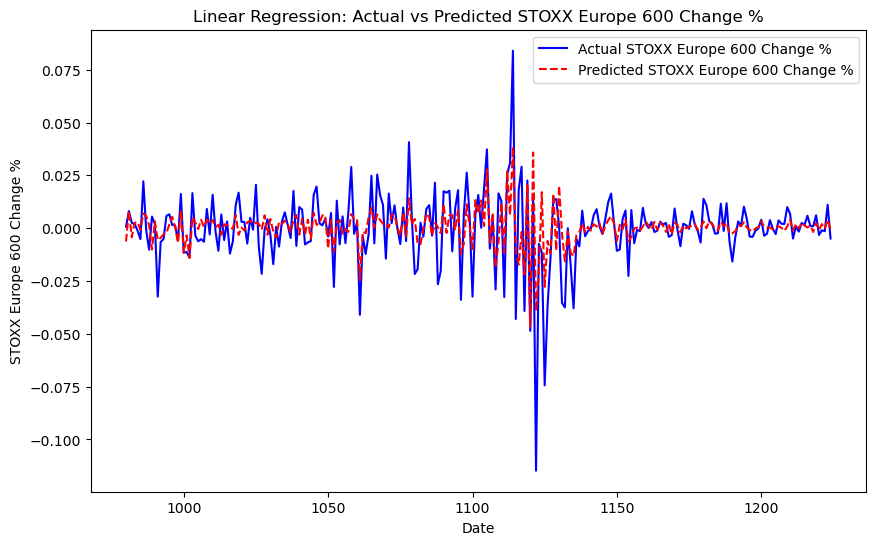

In [49]:
# Convert percentage strings to floats
def percentage_to_float(value):
    if isinstance(value, str):
        return float(value.strip('%')) / 100.0  # Remove '%' and divide by 100
    return value 

for column in ['Euribor Change %', 'SP500 Change %', 'Currency Change %']:
    merged_df[column] = merged_df[column].apply(percentage_to_float)

# Convert target 'Stoxx Change %' to numerical format
merged_df['Stoxx Change %'] = merged_df['Stoxx Change %'].apply(percentage_to_float)

# Features and the label
X_features = merged_df[['Euribor Change %', 'SP500 Change %', 'Currency Change %']]
y_target = merged_df['Stoxx Change %']


# The sizes for training, validation, and testing sets
train_data_size = int(0.6 * len(merged_df))
validation_data_size = int(0.2 * len(merged_df))

# Time-based split
X_train_data = X_features[:train_data_size]
y_train_data = y_target[:train_data_size]

X_validation_data = X_features[train_data_size:train_data_size + validation_data_size]
y_validation_data = y_target[train_data_size:train_data_size + validation_data_size]

X_test_data = X_features[train_data_size + validation_data_size:]
y_test_data = y_target[train_data_size + validation_data_size:]

# The first linear regression model
linear_model = LinearRegression()

# Train the model 
linear_model.fit(X_train_data, y_train_data)

# Predictions on the training set
y_train_predictions = linear_model.predict(X_train_data)
training_mse = mean_squared_error(y_train_data, y_train_predictions)
train_r2 = linear_model.score(X_train_data, y_train_data)*100


# Predictions on the validation set
y_validation_predictions = linear_model.predict(X_validation_data)
validation_mse = mean_squared_error(y_validation_data, y_validation_predictions)
val_r2 = linear_model.score(X_validation_data, y_validation_data)*100


# Predictions on the test set
y_test_predictions = linear_model.predict(X_test_data)
test_mse = mean_squared_error(y_test_data, y_test_predictions)
test_r2 = linear_model.score(X_test_data, y_test_data)*100



# Print the training, validation, and test metrics
print(f"Training error: {training_mse:.8f}")
print(f"Prediction accuracy on training set: {train_r2:.2f}%")
print(f"Validation error: {validation_mse:.8f}")
print(f"Prediction accuracy on validation set: {val_r2:.2f}%")
print(f"Test error: {test_mse:.8f}")
print(f"Prediction accuracy on test set: {test_r2:.2f}%")

# Plot on Test Data
plt.figure(figsize=(10, 6))
plt.plot(y_test_data.index, y_test_data, label="Actual STOXX Europe 600 Change %", color='b')
plt.plot(y_test_data.index, y_test_predictions, label="Predicted STOXX Europe 600 Change %", color='r', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted STOXX Europe 600 Change %')
plt.xlabel('Date')
plt.ylabel('STOXX Europe 600 Change %')
plt.legend()
plt.show()







Training error  0.00000941
Prediction accuracy on training set: 88.70%
Validation error: 0.00005675
Prediction accuracy on validation set: 19.53%
Test error: 0.00021096
Prediction accuracy on test set: 28.20%


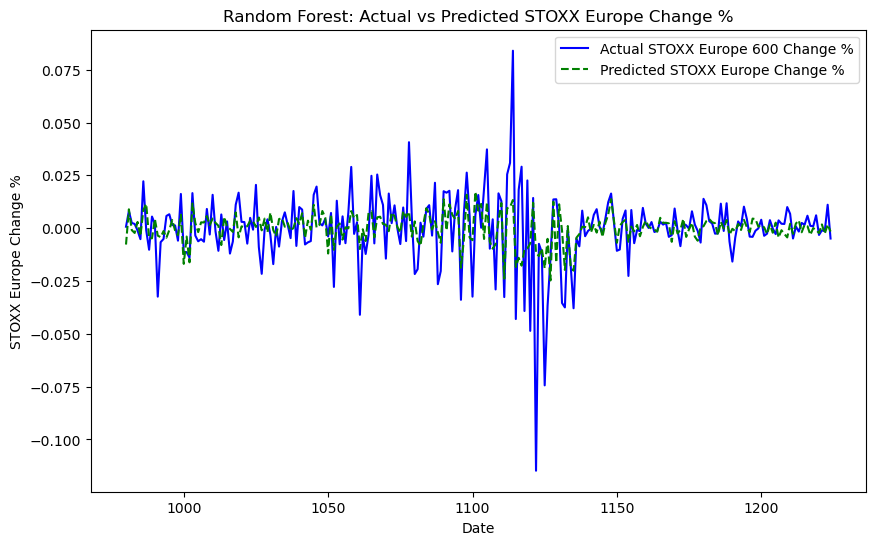

In [50]:
# The second ML method: Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model 
rf_model.fit(X_train_data, y_train_data)

# Predictions on the training set
y_train_predictions_rf = rf_model.predict(X_train_data)
training_error = mean_squared_error(y_train_data, y_train_predictions_rf)
train_rf = rf_model.score(X_train_data, y_train_data)*100


# Predictions on the validation set
y_validation_predictions_rf = rf_model.predict(X_validation_data)
validation_error = mean_squared_error(y_validation_data, y_validation_predictions_rf)
val_rf = rf_model.score(X_validation_data, y_validation_data)*100


# Predictions on the test set 
y_test_predictions_rf = rf_model.predict(X_test_data)
test_error = mean_squared_error(y_test_data, y_test_predictions_rf)
test_rf = rf_model.score(X_test_data, y_test_data) * 100


# Print the training, validation, and test metrics
print(f"Training error  {training_error:.8f}")
print(f"Prediction accuracy on training set: {train_rf:.2f}%")
print(f"Validation error: {validation_error:.8f}")
print(f"Prediction accuracy on validation set: {val_rf:.2f}%")
print(f"Test error: {test_error:.8f}")
print(f"Prediction accuracy on test set: {test_rf:.2f}%")


# Plot Actual vs Predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test_data.index, y_test_data, label="Actual STOXX Europe 600 Change %", color='b')
plt.plot(y_test_data.index, y_test_predictions_rf, label="Predicted STOXX Europe Change %", color='g', linestyle='--')
plt.title('Random Forest: Actual vs Predicted STOXX Europe Change %')
plt.xlabel('Date')
plt.ylabel('STOXX Europe Change %')
plt.legend()
plt.show()
